## Problem - Predicting Spotify Track Popularity with Data Science
#### Understanding what drives song success using metadata

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

In [2]:
spfy_df = pd.read_csv("spotify_data clean.csv")
spfy_df.head()

,track_id,track_name,track_number,track_popularity,explicit,artist_name,artist_popularity,artist_followers,artist_genres,album_id,album_name,album_release_date,album_total_tracks,album_type,track_duration_min
0,3EJS5LyekDim1Tf5rBFmZl,Trippy Mane (ft. Project Pat),4,0,True,Diplo,77,2812821,moombahton,5QRFnGnBeMGePBKF2xTz5z,"d00mscrvll, Vol. 1",2025-10-31,9,album,1.55
1,1oQW6G2ZiwMuHqlPpP27DB,OMG!,1,0,True,Yelawolf,64,2363438,"country hip hop, southern hip hop",4SUmmwnv0xTjRcLdjczGg2,OMG!,2025-10-31,1,single,3.07
2,7mdkjzoIYlf1rx9EtBpGmU,Hard 2 Find,1,4,True,Riff Raff,48,193302,NaN,3E3zEAL8gUYWaLYB9L7gbp,Hard 2 Find,2025-10-31,1,single,2.55
3,67rW0Zl7oB3qEpD5YWWE5w,Still Get Like That (ft. Project Pat & Starrah),8,30,True,Diplo,77,2813710,moombahton,5QRFnGnBeMGePBKF2xTz5z,"d00mscrvll, Vol. 1",2025-10-31,9,album,1.69
4,15xptTfRBrjsppW0INUZjf,ride me like a harley,2,0,True,Rumelis,48,8682,dark r&b,06FDIpSHYmZAZoyuYtc7kd,come closer / ride me like a harley,2025-10-30,2,single,2.39


In [3]:
spfy_df.describe()

,track_number,track_popularity,artist_popularity,artist_followers,album_total_tracks,track_duration_min
count,8582.000000,8582.000000,8582.000000,8.582000e+03,8582.000000,8582.000000
mean,5.772547,52.356211,69.730016,2.403472e+07,13.789443,3.492805
std,6.052792,23.816076,19.645979,3.803180e+07,11.887131,1.057970
min,1.000000,0.000000,0.000000,0.000000e+00,1.000000,0.070000
25%,1.000000,39.000000,60.000000,4.623200e+05,6.000000,2.880000
50%,4.000000,58.000000,74.000000,6.105547e+06,13.000000,3.445000
75%,9.000000,71.000000,84.000000,2.725255e+07,17.000000,3.990000
max,102.000000,99.000000,100.000000,1.455421e+08,181.000000,13.510000


In [4]:
spfy_df.columns

Index(['track_id', 'track_name', 'track_number', 'track_popularity',
       'explicit', 'artist_name', 'artist_popularity', 'artist_followers',
       'artist_genres', 'album_id', 'album_name', 'album_release_date',
       'album_total_tracks', 'album_type', 'track_duration_min'],
      dtype='object')

In [5]:
spfy_df.shape
spfy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8582 entries, 0 to 8581
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   track_id            8582 non-null   object 
 1   track_name          8582 non-null   object 
 2   track_number        8582 non-null   int64  
 3   track_popularity    8582 non-null   int64  
 4   explicit            8582 non-null   bool   
 5   artist_name         8579 non-null   object 
 6   artist_popularity   8582 non-null   int64  
 7   artist_followers    8582 non-null   int64  
 8   artist_genres       5221 non-null   object 
 9   album_id            8582 non-null   object 
 10  album_name          8582 non-null   object 
 11  album_release_date  8582 non-null   object 
 12  album_total_tracks  8582 non-null   int64  
 13  album_type          8582 non-null   object 
 14  track_duration_min  8582 non-null   float64
dtypes: bool(1), float64(1), int64(5), object(8)
memory usag

In [6]:
spfy_df.isnull().sum()

track_id                 0
track_name               0
track_number             0
track_popularity         0
explicit                 0
artist_name              3
artist_popularity        0
artist_followers         0
artist_genres         3361
album_id                 0
album_name               0
album_release_date       0
album_total_tracks       0
album_type               0
track_duration_min       0
dtype: int64

In [7]:
spfy_df["album_release_date"] = pd.to_datetime(spfy_df["album_release_date"], errors="coerce")
spfy_df["track_duration_min"] = pd.to_numeric(spfy_df["track_duration_min"], errors="coerce")

In [8]:
spfy_df.duplicated().sum()
spfy_df.drop_duplicates(inplace=True)

In [9]:
# Track Age
spfy_df["release_year"] = spfy_df["album_release_date"].dt.year
spfy_df["track_age"] = 2026 - spfy_df["release_year"]

In [10]:
# Artist strength metric
spfy_df["artist_power"] = spfy_df["artist_popularity"] * np.log1p(spfy_df["artist_followers"])

In [11]:
# Genre count per artist
spfy_df["genre_count"] = spfy_df["artist_genres"].apply(lambda x: len(str(x).split(",")))

## EDA

In [13]:
plt.style.use("seaborn-v0_8-whitegrid")

plt.rcParams.update({
    "figure.figsize": (8,5),
    "axes.titlesize": 16,
    "axes.labelsize": 13,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11
})

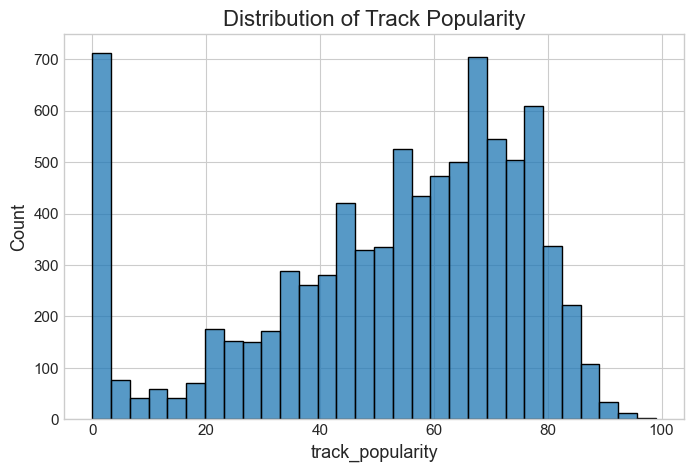

<Figure size 800x500 with 0 Axes>

In [60]:
sns.histplot(spfy_df["track_popularity"], bins=30)
plt.title("Distribution of Track Popularity")
plt.show()
plt.savefig("Distribution of Track Popularity", bbox_inches="tight")

<Axes: xlabel='artist_popularity', ylabel='track_popularity'>

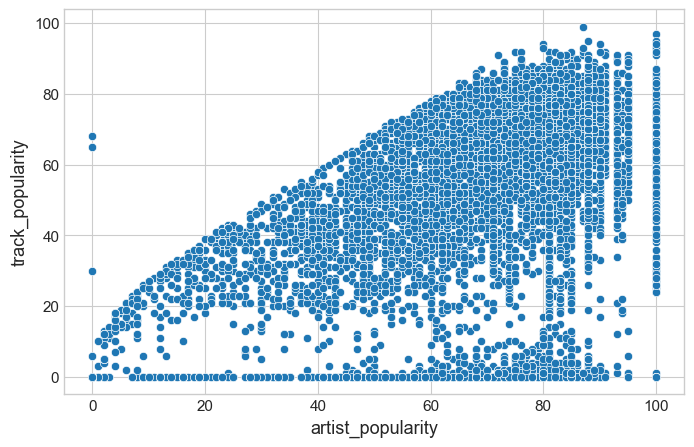

In [15]:
sns.scatterplot(x="artist_popularity", y="track_popularity", data= spfy_df)

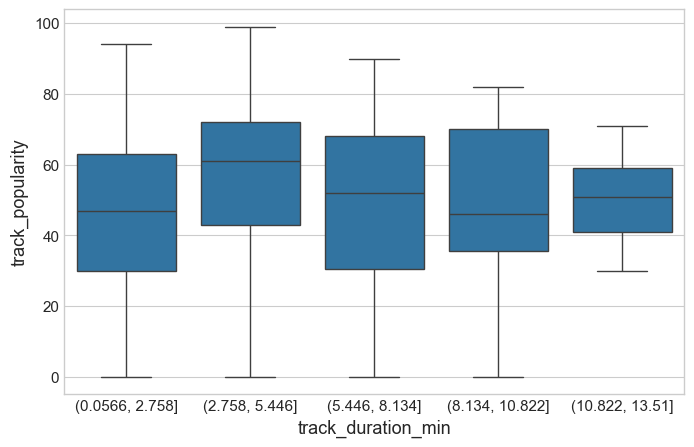

In [62]:
sns.boxplot(x=pd.cut(spfy_df["track_duration_min"], bins=5),
            y=spfy_df["track_popularity"])
plt.savefig("Track Duration Minutes", bbox_inches="tight")

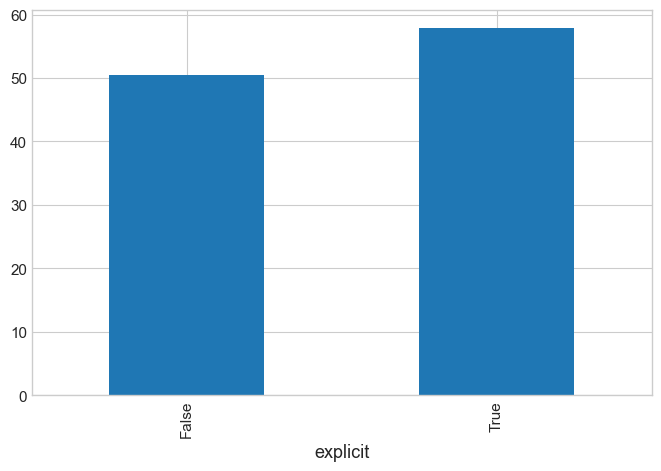

In [64]:
spfy_df.groupby("explicit")["track_popularity"].mean().plot(kind="bar")
plt.savefig("Explicit Vs Non Explicit", bbox_inches="tight")

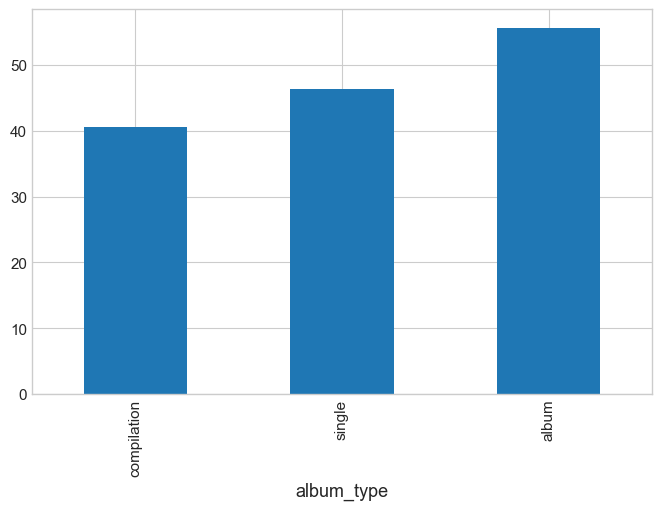

In [66]:
spfy_df.groupby("album_type")["track_popularity"].mean().sort_values().plot(kind="bar")
plt.savefig("Album Type vs Track Popularity", bbox_inches="tight")

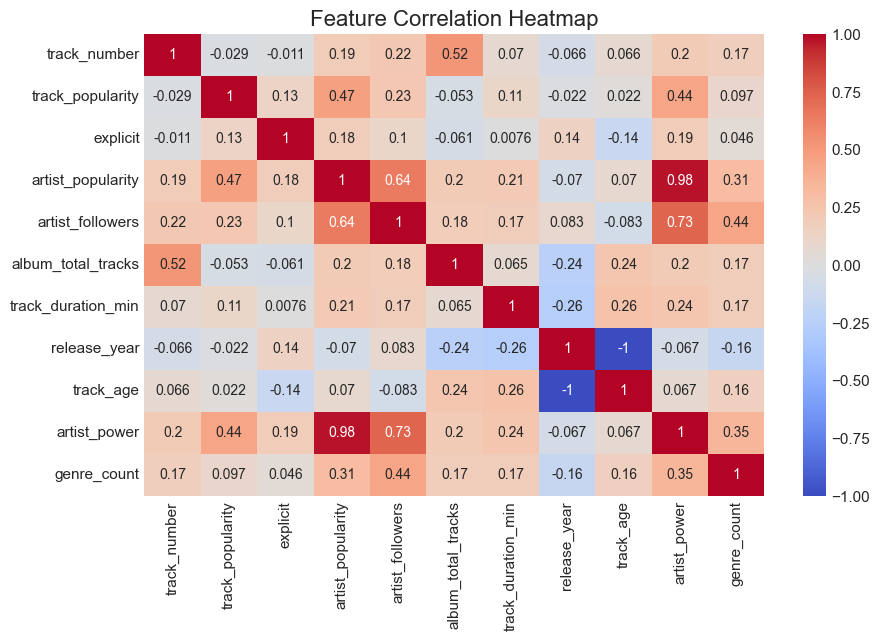

In [72]:
plt.figure(figsize=(10,6))
sns.heatmap(spfy_df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.savefig("heatmap.png", dpi=300, bbox_inches="tight")
plt.show()

## Predictive Modeling

In [21]:
target = "track_popularity"

In [22]:
features = [
    "artist_popularity",
    "artist_followers",
    "track_duration_min",
    "album_total_tracks",
    "track_age",
    "artist_power",
    "genre_count"
]

In [23]:
X = spfy_df[features].fillna(0)
y = spfy_df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


In [24]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [25]:
preds = model.predict(X_test)

print("RMSE:", np.sqrt(mean_squared_error(y_test, preds)))
print("R2:", r2_score(y_test, preds))

RMSE: 19.07712329471127
R2: 0.38767612559881603


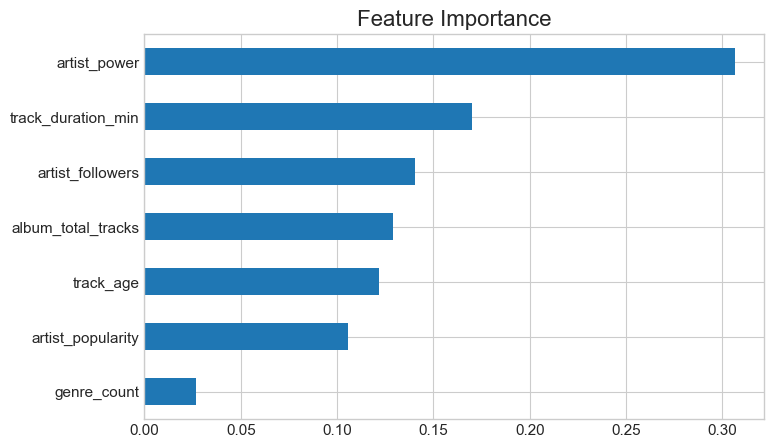

In [58]:
importance = pd.Series(model.feature_importances_, index=features)
importance.sort_values().plot(kind="barh")
plt.title("Feature Importance")
plt.savefig("Feature Importance", bbox_inches="tight")